In [16]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Lambda

from collections import deque
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib inline

from utils import load_weights, process_output, draw_boxes, preprocess, remove_duplicates

In [17]:
keras.backend.set_image_dim_ordering('th')

In [18]:
model = Sequential()

#normalize data
model.add(Lambda(lambda x: x/128 - 1,input_shape=(3,448,448)))

#layer 1
model.add(Convolution2D(16, 3, 3,border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

#layer 2
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))

#layer 3
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))

#layer 4
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))

#layer 5
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))

#layer 6
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))

#layer 7
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))

#layer 8
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))

#layer 9
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())

#layer 10
model.add(Dense(256))

#layer 11
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))

#output layer
model.add(Dense(1470))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 3, 448, 448)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 448, 448)      448       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 448, 448)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 224, 224)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 224, 224)      4640      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 224, 224)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 112, 112)      0         
__________

In [20]:
load_weights(model,'/home/ivan/darknet/yolo-tiny.weights')

(720, 1280, 3)

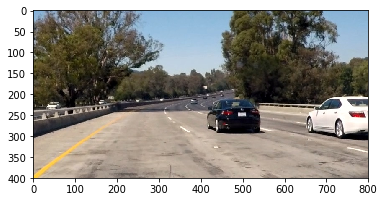

In [21]:
test_image = cv2.imread('test_images/test1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

plt.imshow(test_image[200:600, 400:1200])
test_image.shape

[156, 0]

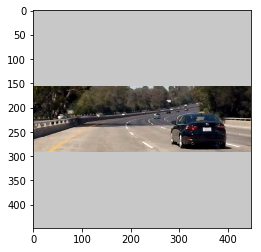

In [22]:
processed, padhw, shavedim, resized = preprocess(test_image, shave=True)
plt.imshow(resized)
padhw

In [23]:
prediction = model.predict(np.array([processed]))[0]
boxes = process_output(prediction, padhw=padhw, shaved=True)

len(boxes)

0

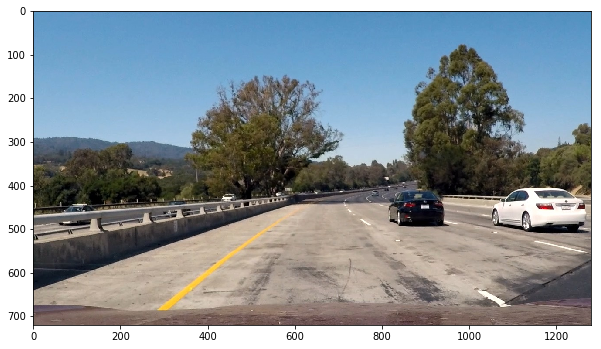

In [24]:
boxes = remove_duplicates(boxes, test_image)
img =  draw_boxes(boxes, test_image)
plt.figure(figsize=[10,10])
plt.imshow(img)

In [25]:
class Pipeline:
    def __init__(self):
        self.boxes = []
        self.dropped = 0
        self.history = deque(maxlen=8)
        self.first_frames = True
    
    def apply_threshold(self, boxes):
        if len(boxes) == 0 and len(self.history) > 0:
            self.history.popleft()
        else:
            #create blank heatmap to store the most recent boxes
            heatmap = np.zeros([720,1280], np.int)
            for box in boxes:
                # Add += 1 for all pixels inside each box
                heatmap[box.y1:box.y2, box.x1:box.x2] += 1
            
            #add current heatmap to deque of heatmaps
            self.history.append(heatmap)
            
            #make sure to only use heatmap detection if there is enough information
            if len(self.history) > 4:
                self.first_frames = False
            else: 
                self.first_frames = True
            
            #add heatmaps together to make full heatmap
            if not self.first_frames:
                full_heatmap = np.zeros([720,1280], np.int)
                for preheat in self.history:
                    full_heatmap = np.add(full_heatmap, preheat)
                
                #if the center point of a box is not in an area the heatmap recognizes, remove that box
                new_boxes = []
                for box in boxes:
                    if full_heatmap[int(box.y), int(box.x)] > 2:
                        new_boxes.append(box)
                return new_boxes

        return boxes

        
    
    def pipeline(self,img):
        # each detection is ordered in terms of priority. A detection higher on the list will override a similar
        # detection lower down.
        # initial detection preformed on entire image.
        transposed, padhw, shavedim, resized = preprocess(img,shave=False)
        yolo_output = model.predict(np.array([transposed]))[0]
        boxes = process_output(yolo_output, threshold=0.20, padhw=padhw,shaved=False, shavedim=shavedim)
        
        #preform detection on each box in the stored previous boxes
        for box in self.boxes:
            offset = 150
            shavedim = [box.y1 - offset, box.y2 + offset, box.x1 - offset, box.x2 + offset]
            transposed, padhw, shavedim, resized = preprocess(img, shave=True, shavedim=shavedim)
            yolo_output = model.predict(np.array([transposed]))[0]
            boxes2 = process_output(yolo_output, threshold=0.35, padhw=padhw, shaved=True, shavedim=shavedim)
            boxes += boxes2 
        
        # last detection preformed picture shaved to just the highway ahead
        transposed, padhw, shavedim, resized = preprocess(img, shave=True, shavedim=(350,500, 500,1000))
        yolo_output = model.predict(np.array([transposed]))[0]
        boxes2 = process_output(yolo_output, threshold=0.30, padhw=padhw, shaved=True, shavedim=shavedim)
        boxes += boxes2  
        
                    
        #remove duplacate boxes        
        boxes = remove_duplicates(boxes, img)
        boxes = self.apply_threshold(boxes)
        if(len(boxes) < len(self.boxes)) and self.dropped < 3:
            self.dropped += 1
            boxes = self.boxes
        else:
            self.dropped = 0
            
        drawn = draw_boxes(boxes, img)
        self.boxes = boxes
        return drawn

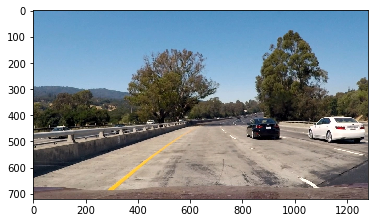

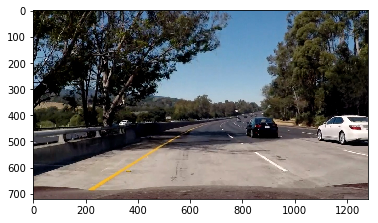

In [26]:
pipe = Pipeline()
test_image2 = cv2.imread('test_images/test1.jpg')
test_image2 = cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB)
test_image2 = pipe.pipeline(test_image2)
plt.imshow(test_image2)
plt.figure()
test_image3 = cv2.imread('test_images/test5.jpg')
test_image3 = cv2.cvtColor(test_image3, cv2.COLOR_BGR2RGB)
test_image3 = pipe.pipeline(test_image3)
plt.imshow(test_image3)


In [27]:
pipe = Pipeline()
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
lane_clip = clip1.fl_image(pipe.pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4



  3%|▎         | 42/1261 [00:17<08:05,  2.51it/s]

KeyboardInterrupt: 